
Authors: Paula Biderman Mato and Pablo Fuentes Chemes


# Language Modelling
# Lab Assignment: Neural models for word vector representation.

# Introduction
In this notebook, we develop and train a word embedding model designed to predict a central word based on its surrounding context.
The model is trained on a corpus of 30,000 news sentences and aims to learn semantic representations of words.
Additionally, we evaluate the quality of the embeddings through qualitative analysis (cosine similarity, t-SNE visualization) and quantitative analysis (text classification on Reuters dataset).

# 1. Setup and Imports

In [28]:
import os, re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Embedding, Lambda, Dense, GlobalMaxPooling1D, Conv1D, MaxPooling1D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.datasets import reuters
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import Counter


In [2]:
# Path to dataset
DATA_PATH = 'eng_news_2024_30k_sentences.txt'

In [3]:
# Read raw sentences
with open(DATA_PATH, 'r', encoding='utf-8') as f:
    sentences = [line.strip() for line in f if line.strip()]

print(f"Loaded {len(sentences)} sentences.")
print(sentences[:5])

Loaded 30000 sentences.
['$10-$15 suggested donation goes to Falmouth Land Trust.', '$20,000: Lower Adirondack Pride Festival, June 1 in City Park, Glens Falls.', '$239.4 billion (32nd), comparable to Hungary.', '$35, $75 family of three or more.', '£1,200: Provision of funding for Year 1 & Year 2 children to attend Enchantica Christmas Show / Grove Road Community Primary School.']


# 2. Utility Functions


In [46]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

def visualize_tsne_embeddings(words, embeddings, word_index, filename=None):
    """
    Visualizes t-SNE embeddings of selected words.

    Args:
        words (list): List of words to visualize.
        embeddings (numpy.ndarray): Array containing word embeddings.
        word_index (dict): Mapping of words to their indices in the embeddings array.
        filename (str, optional): File to save the visualization. If None, plot is displayed.

    Returns:
        None
    """
    # Filter the embeddings for the selected words
    indices = [word_index[word] for word in words]
    selected_embeddings = embeddings[indices]

    # Set perplexity for t-SNE, it's recommended to use a value less than the number of selected words
    perplexity = min(5,len(words) - 1)

    # Use t-SNE to reduce dimensionality
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=0)
    reduced_embeddings = tsne.fit_transform(selected_embeddings)

    # Plotting
    plt.figure(figsize=(10, 10))
    for i, word in enumerate(words):
        plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1])
        plt.annotate(word, xy=(reduced_embeddings[i, 0], reduced_embeddings[i, 1]), xytext=(5, 2),
                     textcoords='offset points', ha='right', va='bottom')

    # Save or display the plot
    if filename:
        plt.savefig(filename)
    else:
        plt.show()


def visualize_all_tsne_embeddings(embeddings, word_index, words_to_plot, words_to_label=None, filename=None):
    """
    Visualizes t-SNE embeddings of selected words with optional labeling.

    Args:
        embeddings (numpy.ndarray): Array containing word embeddings.
        word_index (dict): Mapping of words to their indices in the embeddings array.
        words_to_plot (list): List of words to plot.
        words_to_label (list, optional): List of words to label. Defaults to None.
        filename (str, optional): File to save the visualization. If None, plot is displayed.

    Returns:
        None
    """
    # Create a reverse mapping from index to word
    index_word = {index: word for word, index in word_index.items()}

    # Ensure words_to_label is a subset of words_to_plot
    if words_to_label is None:
        words_to_label = words_to_plot
    words_to_label = set(words_to_label).intersection(words_to_plot)

    # Filter the embeddings for the words to plot
    indices_to_plot = [word_index[word] for word in words_to_plot if word in word_index]
    selected_embeddings = embeddings[indices_to_plot]

    # Set perplexity for t-SNE, it's recommended to use a value less than the number of selected words
    perplexity = min(5,len(words_to_plot) - 1)

    # Use t-SNE to reduce dimensionality
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=0)
    reduced_embeddings = tsne.fit_transform(selected_embeddings)

    # Plotting
    plt.figure(figsize=(12, 12))
    for i, index in enumerate(indices_to_plot):
        plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], alpha=0.5)
        if index_word[index] in words_to_label:  # Annotate only selected words
            plt.annotate(index_word[index],
                         xy=(reduced_embeddings[i, 0], reduced_embeddings[i, 1]),
                         xytext=(5, 2),
                         textcoords='offset points',
                         ha='right',
                         va='bottom')


CONTRACTIONS = {
    "he's": "he is",
    "she's": "she is",
    "it's": "it is",
    "that's": "that is",
    "what's": "what is",
    "who's": "who is",
    "i'm": "i am",
    "you're": "you are",
    "they're": "they are",
    "we're": "we are",
    "can't": "can not",
    "cannot": "can not",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "here's": "here is",
    "how's": "how is",
    "i'd": "i would",
    "i'll": "i will",
    "i've": "i have",
    "isn't": "is not",
}

def expand_contractions(text):
    # Normalizar apostrofe “curly” a straight
    text = text.replace("’", "'")
    # Expandir cada contracción del diccionario (word boundaries)
    for contr, full in CONTRACTIONS.items():
        pattern = r"\b" + re.escape(contr) + r"\b"
        text = re.sub(pattern, full, text, flags=re.IGNORECASE)
    return text


def preprocess_text(text):
    # a) minúsculas
    text = text.lower()
    # b) expandir contracciones
    text = expand_contractions(text)
    # c) eliminar posesivos 's (lo que quede de view's, king's, etc.)
    text = re.sub(r"'s\b", "", text)
    # 1) Rangos numéricos con pm/am
    text = re.sub(r'\b(\d+)\s*p\.?m\.?', '<num> pm', text)
    text = re.sub(r'\b(\d+)\s*a\.?m\.?', '<num> am', text)
    # 2) Números, decimales, miles y ordinales
    text = re.sub(r'[$£€]?[\d]+(?:[.,]\d+)*(?:st|nd|rd|th)?', '<num>', text)
    # 4) Elimina símbolos de moneda y todo excepto letras, espacios y <>
    text = re.sub(r'[$£€]', ' ', text)
    text = re.sub(r'[^a-zñáéíóúü<> ]+', ' ', text)
    # 3) Unifica múltiples <num>
    text = re.sub(r'(?:<num>\s+){2,}', '<num> ', text)
    # 5) Colapsa espacios
    text = re.sub(r'\s+', ' ', text).strip()
    return text


def generate_context_target_pairs(sequences, window):
    """
    From integer sequences generate (context, target) pairs for CBOW.
    """
    inputs, targets = [], []
    maxlen = window * 2
    for seq in sequences:
        for i in range(window, len(seq) - window):
            context = seq[i-window:i] + seq[i+1:i+1+window]
            target = seq[i]
            if len(context) == maxlen:
                inputs.append(context)
                targets.append(seq[i])
    return np.array(inputs), np.array(targets)


def build_cbow_model(vocab_size, window, embedding_dim):
    """
    Builds a CBOW model: average context embeddings -> hidden layers -> softmax
    """
    maxlen = window * 2
    inp = Input(shape=(maxlen,), name='context_inputs')
    emb = Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length=maxlen,
                    name='embedding')(inp)
    avg = Lambda(lambda x: tf.reduce_mean(x, axis=1), name='average_context')(emb)
    x = Dense(256, activation='relu')(avg)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    out = Dense(vocab_size, activation='softmax', name='target_output')(x)
    model = Model(inputs=inp, outputs=out, name=f'cbow_w{window}_d{embedding_dim}')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


def get_callbacks():
    """EarlyStopping, ReduceLROnPlateau, ModelCheckpoint"""
    es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=0)
    rl = ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.5, min_lr=1e-6, verbose=0)
    return [es, rl]


def plot_history(history, figsize=(12, 5)):
    """
    Plot training & validation accuracy and loss from a keras History object.

    Args:
        history: keras.callbacks.History returned by model.fit(...)
        figsize: tuple con el tamaño de la figura (ancho, alto)
    """
    # Extrae los valores
    acc       = history.history.get('accuracy', [])
    val_acc   = history.history.get('val_accuracy', [])
    loss      = history.history.get('loss', [])
    val_loss  = history.history.get('val_loss', [])
    epochs    = range(1, len(acc) + 1)

    plt.figure(figsize=figsize)

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc,      label='Training Acc')
    plt.plot(epochs, val_acc,  label='Validation Acc')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss,     label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


# 3. Preprocessing

To prepare the training data, we first preprocess the text with the function defined above.
Later, tokenize the sentences using a Keras Tokenizer, limiting the vocabulary size to the 90% most frequent words. Each sentence is converted into a sequence of integer word indices.

In [54]:
# Apply to all sentences
clean_sentences = [preprocess_text(s) for s in sentences]

# Quick sanity check
print(sentences[:5])
print(clean_sentences[:5])

['$10-$15 suggested donation goes to Falmouth Land Trust.', '$20,000: Lower Adirondack Pride Festival, June 1 in City Park, Glens Falls.', '$239.4 billion (32nd), comparable to Hungary.', '$35, $75 family of three or more.', '£1,200: Provision of funding for Year 1 & Year 2 children to attend Enchantica Christmas Show / Grove Road Community Primary School.']
['<num> suggested donation goes to falmouth land trust', '<num> lower adirondack pride festival june <num> in city park glens falls', '<num> billion <num> comparable to hungary', '<num> family of three or more', '<num> provision of funding for year <num> year <num> children to attend enchantica christmas show grove road community primary school']


In [55]:
vocab_size = 11260
# Tokenize the sentences
# Initialize a Keras Tokenizer and fit it on the loaded sentences. Each word will be assigned a unique integer index.
# OOV (out of vocabulary) token is used for rare words.
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(clean_sentences)
counts = tokenizer.word_counts

# 2) Calcula cobertura cumulativa
total_tokens = sum(counts.values())
cum = 0
threshold = 0.90  # cubrir 90% del corpus
for i, (_, cnt) in enumerate(counts.items(), start=1):
    cum += cnt
    if cum/total_tokens >= threshold:
        vocab_size = i
        break

print(f"Para cubrir el 90% del corpus te basta con vocab_size ≃ {vocab_size}")

sequences = tokenizer.texts_to_sequences(clean_sentences)
word_index = tokenizer.word_index
print(f"Vocabulary size: {len(word_index)}")

Para cubrir el 90% del corpus te basta con vocab_size ≃ 11260
Vocabulary size: 39153


# 4. Experiments Loop: Training Multiple CBOW Models

In this section, we systematically train multiple continuous bag-of-words (CBOW) embedding models by varying two key hyperparameters:

1. **Context window size** (`context_windows`): number of words on each side of the target (e.g., 2 or 5).
2. **Embedding dimension** (`embedding_dims`): size of the vector for each word (50, 100, or 200).

For each `(window, dim)` combination:

- Generate (context, target) pairs using `generate_context_target_pairs(sequences, window)`.
- Split the data into training (90%) and validation (10%) sets.
- Build the model with `build_cbow_model(vocab_size, window, dim)`.
- Train for up to 100 epochs with early stopping and learning-rate reduction callbacks.
- Plot training/validation accuracy and loss via `plot_history`.
- Extract the learned embeddings from the embedding layer and save them to disk as `embeddings_w{window}_d{dim}.npy`.
- Store each model, its history, and embedding matrix in the `results` dictionary for downstream analysis.


Window=2: 481814 samples
Training CBOW: window=2, dim=50
Epoch 1/100
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.0852 - loss: 7.2171 - val_accuracy: 0.1256 - val_loss: 6.2299 - learning_rate: 5.0000e-04
Epoch 2/100
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - accuracy: 0.1286 - loss: 6.2386 - val_accuracy: 0.1452 - val_loss: 6.0601 - learning_rate: 5.0000e-04
Epoch 3/100
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.1459 - loss: 6.0498 - val_accuracy: 0.1534 - val_loss: 5.9687 - learning_rate: 5.0000e-04
Epoch 4/100
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.1563 - loss: 5.9342 - val_accuracy: 0.1616 - val_loss: 5.9089 - learning_rate: 5.0000e-04
Epoch 5/100
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.1632 - loss: 5.8505 - val_accuracy: 0.1646 - val_loss: 5.8684 - learning_rate: 5.0000e-04
Epoch 6/100
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.1693 - loss: 5.7875 - val_accuracy: 0.1674 - val_loss: 5.8354 - learning_

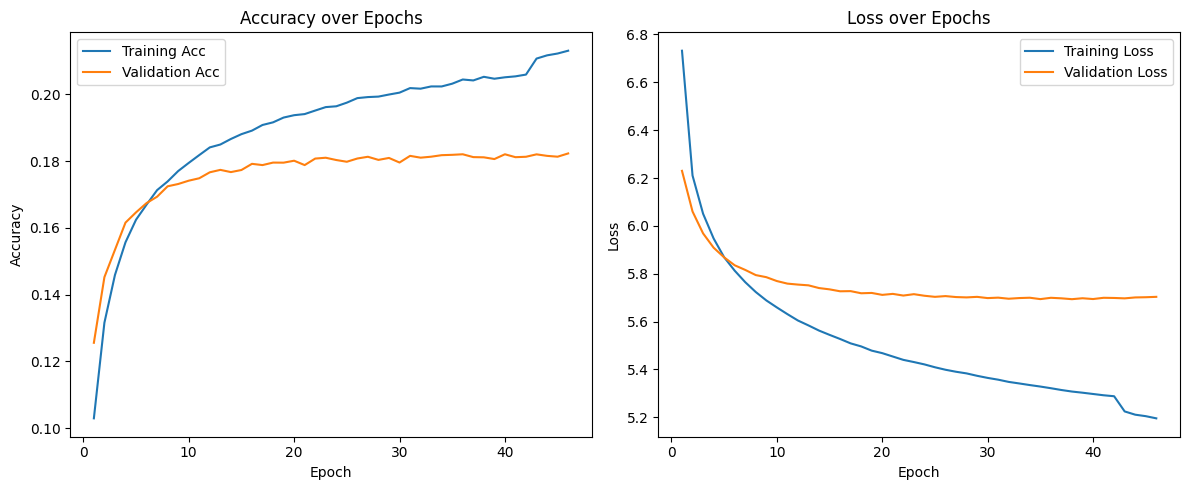

Saved embeddings_w2_d50.npy with shape (11260, 50)
Training CBOW: window=2, dim=100
Epoch 1/100
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - accuracy: 0.0864 - loss: 7.2119 - val_accuracy: 0.1299 - val_loss: 6.2232 - learning_rate: 5.0000e-04
Epoch 2/100
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - accuracy: 0.1301 - loss: 6.2249 - val_accuracy: 0.1484 - val_loss: 6.0442 - learning_rate: 5.0000e-04
Epoch 3/100
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.1479 - loss: 6.0283 - val_accuracy: 0.1578 - val_loss: 5.9511 - learning_rate: 5.0000e-04
Epoch 4/100
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.1583 - loss: 5.9129 - val_accuracy: 0.1631 - val_loss: 5.8908 - learning_rate: 5.0000e-04
Epoch 5/100
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.1667 - loss: 5.8239 - val_accuracy: 0.1656 - val_loss: 5.8513 - learning_rate: 5.0000e-04
Epoch 6/100
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.1713 - loss: 5.7553 - val_accuracy: 0.1701 - v

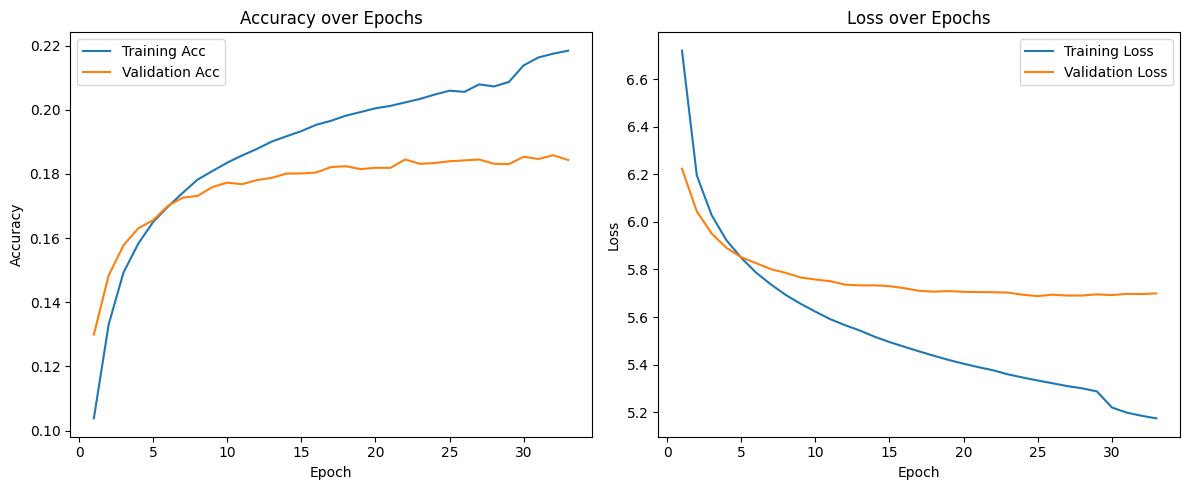

Saved embeddings_w2_d100.npy with shape (11260, 100)
Training CBOW: window=2, dim=200
Epoch 1/100
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - accuracy: 0.0863 - loss: 7.1982 - val_accuracy: 0.1310 - val_loss: 6.2100 - learning_rate: 5.0000e-04
Epoch 2/100
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - accuracy: 0.1312 - loss: 6.2118 - val_accuracy: 0.1475 - val_loss: 6.0317 - learning_rate: 5.0000e-04
Epoch 3/100
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.1483 - loss: 6.0133 - val_accuracy: 0.1580 - val_loss: 5.9388 - learning_rate: 5.0000e-04
Epoch 4/100
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.1601 - loss: 5.8931 - val_accuracy: 0.1655 - val_loss: 5.8772 - learning_rate: 5.0000e-04
Epoch 5/100
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.1681 - loss: 5.8136 - val_accuracy: 0.1694 - val_loss: 5.8425 - learning_rate: 5.0000e-04
Epoch 6/100
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - accuracy: 0.1739 - loss: 5.7559 - val_accuracy: 0.1723 -

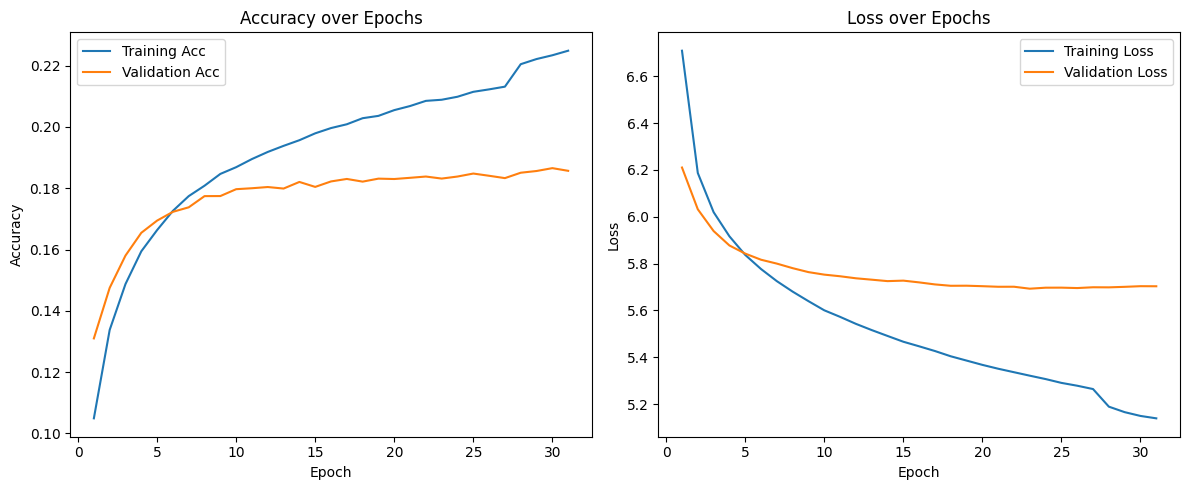

Saved embeddings_w2_d200.npy with shape (11260, 200)
Window=5: 311919 samples
Training CBOW: window=5, dim=50
Epoch 1/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.0615 - loss: 7.5540 - val_accuracy: 0.0898 - val_loss: 6.5198 - learning_rate: 5.0000e-04
Epoch 2/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.0907 - loss: 6.5164 - val_accuracy: 0.0976 - val_loss: 6.4288 - learning_rate: 5.0000e-04
Epoch 3/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.0985 - loss: 6.3711 - val_accuracy: 0.1034 - val_loss: 6.3584 - learning_rate: 5.0000e-04
Epoch 4/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.1098 - loss: 6.2599 - val_accuracy: 0.1111 - val_loss: 6.3110 - learning_rate: 5.0000e-04
Epoch 5/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.1173 - loss: 6.1735 - val_accuracy: 0.1155 - val_loss: 6.2751 - learning_rate: 5.0000e-04
Epoch 6/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.1257 - loss: 6.0989 

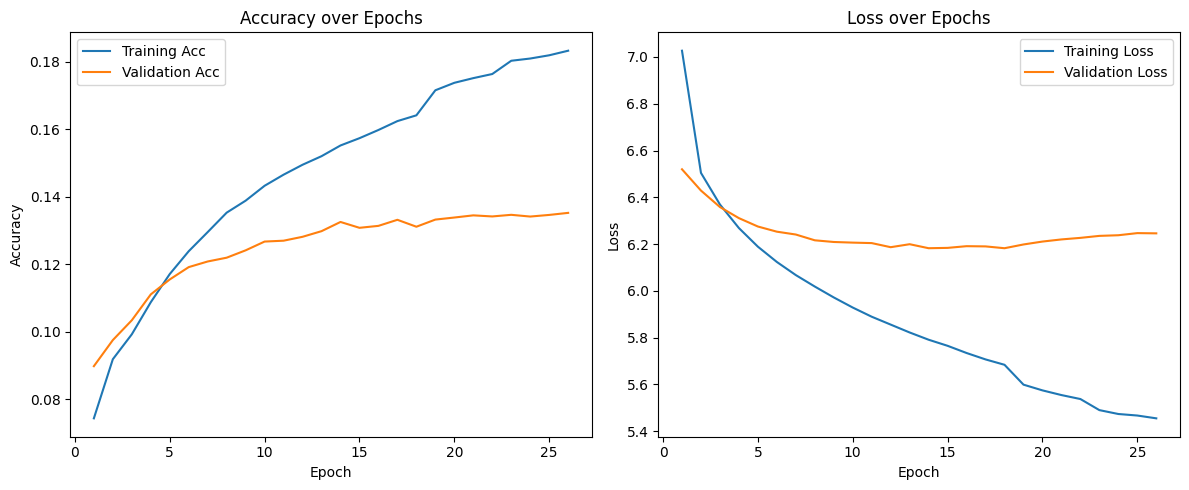

Saved embeddings_w5_d50.npy with shape (11260, 50)
Training CBOW: window=5, dim=100
Epoch 1/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.0609 - loss: 7.5587 - val_accuracy: 0.0916 - val_loss: 6.5155 - learning_rate: 5.0000e-04
Epoch 2/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.0905 - loss: 6.5222 - val_accuracy: 0.0981 - val_loss: 6.4154 - learning_rate: 5.0000e-04
Epoch 3/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.1018 - loss: 6.3651 - val_accuracy: 0.1068 - val_loss: 6.3499 - learning_rate: 5.0000e-04
Epoch 4/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.1121 - loss: 6.2374 - val_accuracy: 0.1120 - val_loss: 6.2950 - learning_rate: 5.0000e-04
Epoch 5/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.1234 - loss: 6.1390 - val_accuracy: 0.1180 - val_loss: 6.2562 - learning_rate: 5.0000e-04
Epoch 6/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.1293 - loss: 6.0689 - val_accuracy: 0.1219 - v

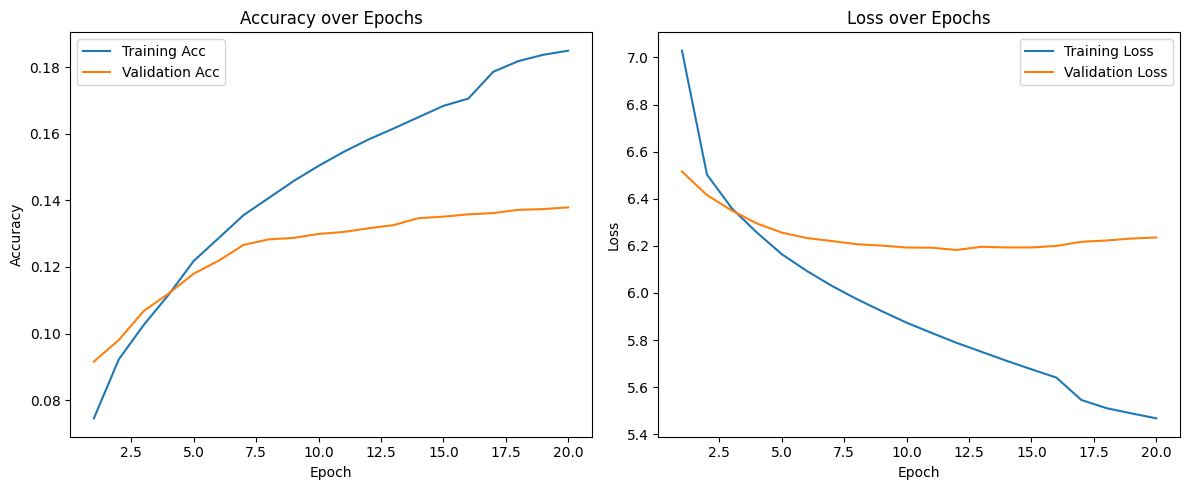

Saved embeddings_w5_d100.npy with shape (11260, 100)
Training CBOW: window=5, dim=200
Epoch 1/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.0613 - loss: 7.5571 - val_accuracy: 0.0915 - val_loss: 6.5105 - learning_rate: 5.0000e-04
Epoch 2/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.0933 - loss: 6.4956 - val_accuracy: 0.1016 - val_loss: 6.4114 - learning_rate: 5.0000e-04
Epoch 3/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.1054 - loss: 6.3396 - val_accuracy: 0.1113 - val_loss: 6.3281 - learning_rate: 5.0000e-04
Epoch 4/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.1165 - loss: 6.2222 - val_accuracy: 0.1170 - val_loss: 6.2695 - learning_rate: 5.0000e-04
Epoch 5/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.1262 - loss: 6.1151 - val_accuracy: 0.1225 - val_loss: 6.2356 - learning_rate: 5.0000e-04
Epoch 6/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.1337 - loss: 6.0377 - val_accuracy: 0.1252 -

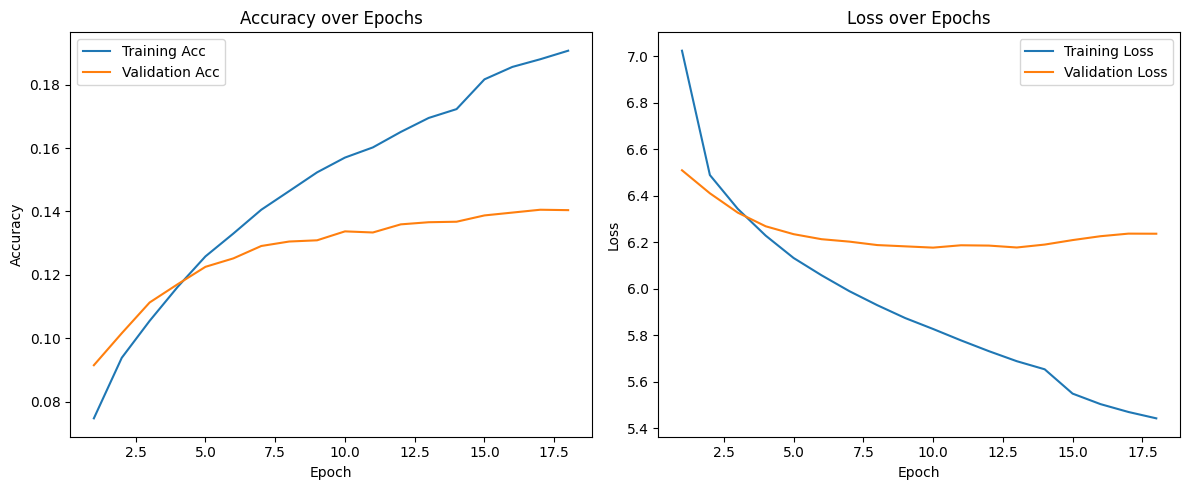

Saved embeddings_w5_d200.npy with shape (11260, 200)


In [27]:
# grid of hyperparameters
context_windows = [2, 5]           # number of words on each side
embedding_dims  = [50, 100, 200]   # embedding vector sizes

results = {}

for window in context_windows:
    maxlen = window * 2

    # 1) genera pares contexto–objetivo para este window
    X, y = generate_context_target_pairs(sequences, window)
    print(f"Window={window}: {X.shape[0]} samples")

    # 2) split train/val
    x_tr, x_val, y_tr, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

    for dim in embedding_dims:
        print(f"Training CBOW: window={window}, dim={dim}")

        # Build model using the utility function
        model = build_cbow_model(vocab_size, window, dim)

        # Train
        history = model.fit(
            x_tr, y_tr,
            validation_data=(x_val, y_val),
            epochs=100,
            batch_size=64,
            callbacks=get_callbacks(),
            verbose=1
        )

        plot_history(history)

        # Extract and save embeddings to disk
        emb_matrix = model.get_layer('embedding').get_weights()[0]
        np.save(f'embeddings_w{window}_d{dim}.npy', emb_matrix)
        print(f"Saved embeddings_w{window}_d{dim}.npy with shape {emb_matrix.shape}")

        # Store results for later analysis
        results[(window, dim)] = {
            'model': model,
            'history': history,
            'embeddings': emb_matrix
        }


# 5. Embedding Analysis: Cosine Similarity and t-SNE Visualization

In this section, we perform a qualitative evaluation of each pretrained embedding matrix stored in the `results` dictionary:

1. **Load target words**  
   We read a list of words of interest from `target_words.txt`.

2. **Iterate over each `(window, dim)` combination**  
   For each model configuration, retrieve its embedding matrix.

3. **Cosine similarity**  
   For the first 10 target words, compute their cosine similarity against the entire vocabulary. We then display each word’s top 10 nearest neighbors (highest similarity scores).

4. **t-SNE visualization**  
   Select up to 100 of the target words, project their high-dimensional vectors down to 2D via t-SNE, and plot the points—labeling each with its word. This allows us to visually inspect clustering and semantic relationships.


In [42]:
# 1) Load target words
with open('target_words.txt') as f:
    target_words = [w.strip() for w in f]

# 2) Loop over each (window, dim) combination
for (window, dim), info in results.items():
    emb = info['embeddings']
    print(f"\n=== Analysis for window={window}, dim={dim} ===")

    # 3) Cosine similarity for the first 10 target words
    print("\nTop-10 most similar words per target:")
    for word in target_words[:10]:
        idx = tokenizer.word_index.get(word)
        if idx is None or idx >= vocab_size:
            continue
        sims = cosine_similarity([emb[idx]], emb)[0]
        top_idx = sims.argsort()[-11:-1][::-1]
        similar = [tokenizer.index_word[i] for i in top_idx]
        print(f"{word:12s} → {similar}")


=== Analysis for window=2, dim=50 ===

Top-10 most similar words per target:
everyone     → ['anyone', 'god', 'me', 'it', 'pensioners', 'everything', 'them', 'someone', 'donors', 'suitable']
music        → ['favorites', 'abroad', 'queer', 'computers', 'authentic', 'hyatt', 'candy', 'pride', 'mohammad', 'kenny']
running      → ['pressed', 'touring', 'lined', 'stationed', 'hawaii', 'located', 'carrying', 'sophomore', 'negotiating', 'shut']
worse        → ['more', 'faster', 'less', 'better', 'rather', 'risky', 'bigger', 'erased', 'slower', 'little']
friday       → ['wednesday', 'thursday', 'monday', 'tuesday', 'sunday', 'saturday', 'july', 'nhtsa', 'sept', 'posting']
september    → ['february', 'october', 'july', 'april', 'june', 'december', 'august', 'sept', 'oct', 'march']
someone      → ['something', 'vitamin', 'allah', 'everyone', 'anxious', 'them', 'descent', 'god', 'others', 'barkley']
getting      → ['gaining', 'woke', 'tasked', 'rolled', 'haunting', 'crashing', 'legally', 'walkin

t-SNE of target words **before** training (random init):


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


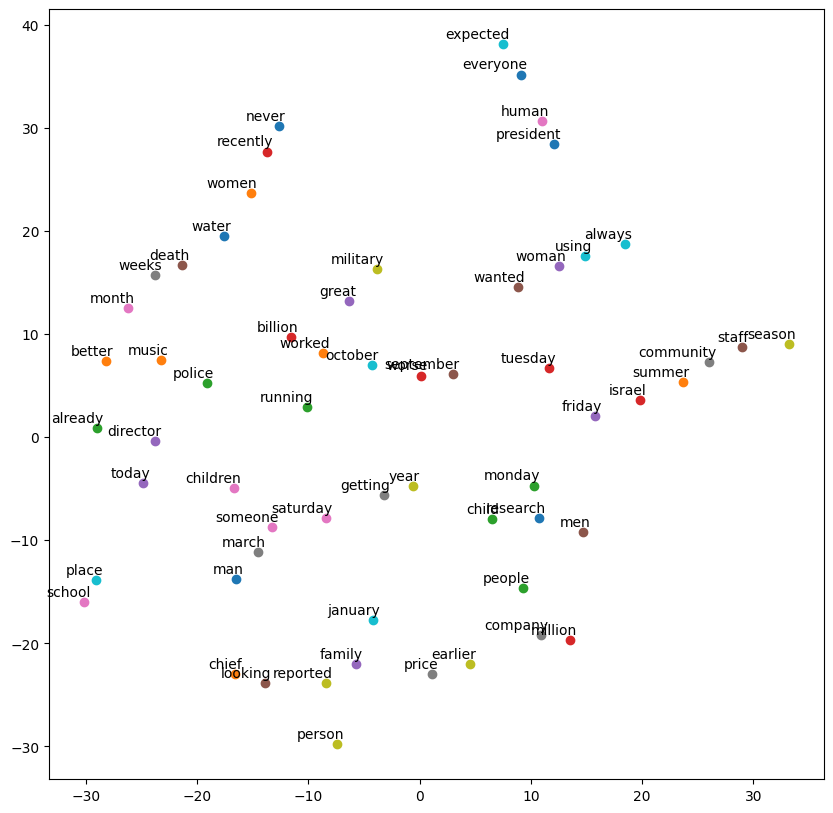

t-SNE of target words **after** training (window=2, dim=50):


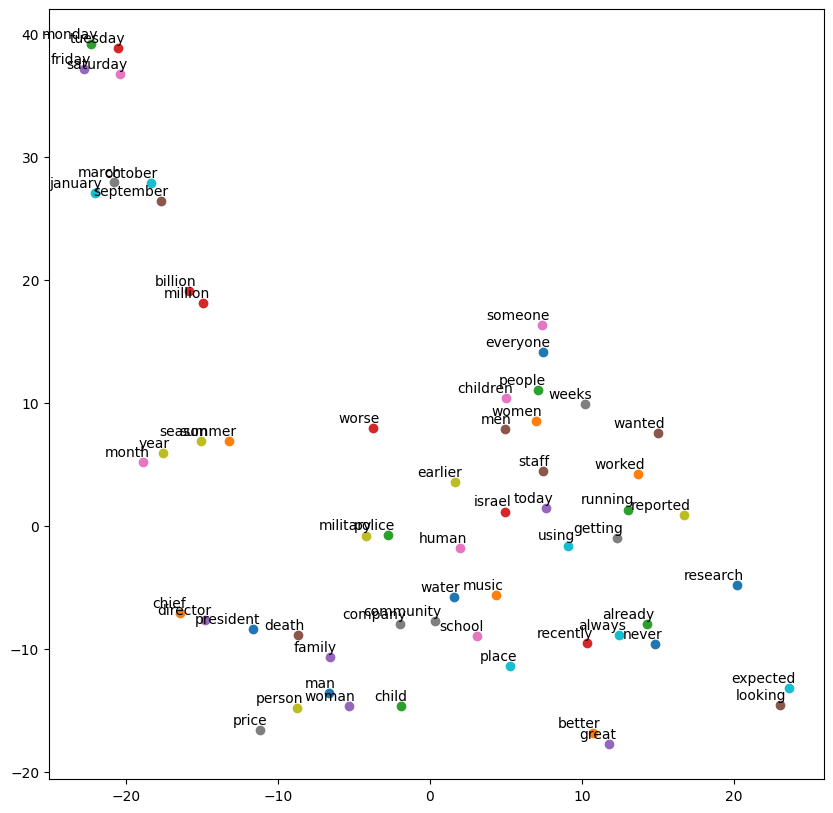

t-SNE of target words **after** training (window=2, dim=100):


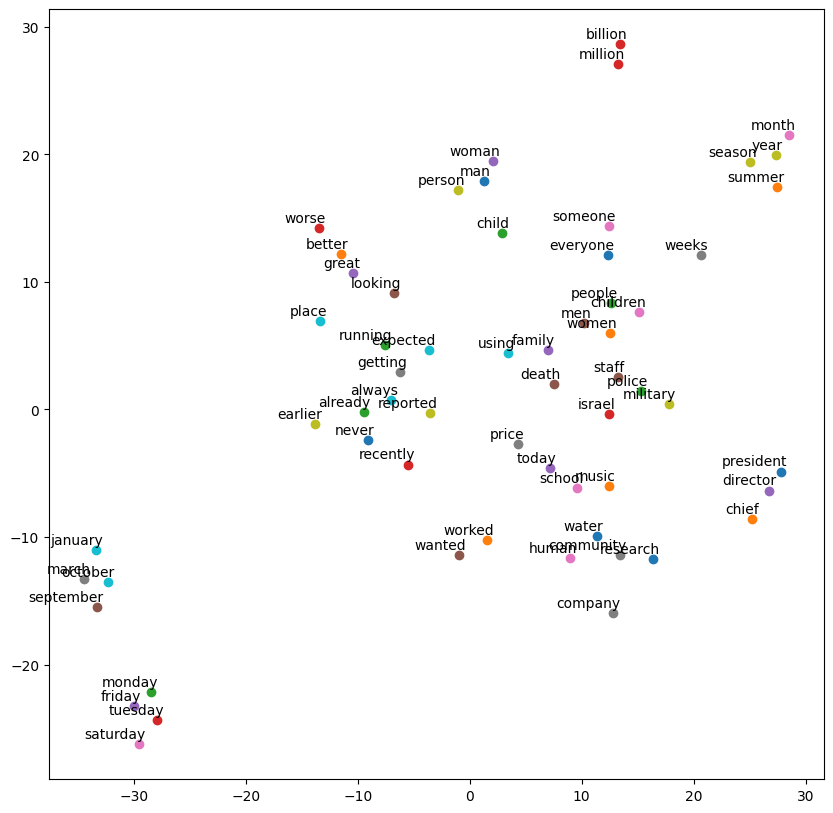

t-SNE of target words **after** training (window=2, dim=200):


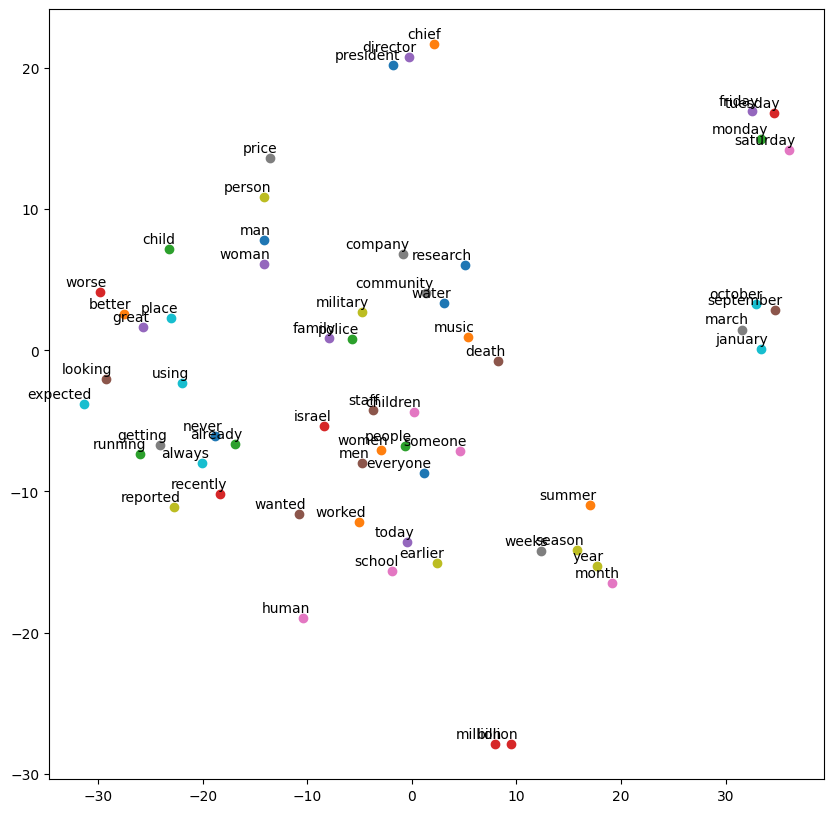

t-SNE of target words **after** training (window=5, dim=50):


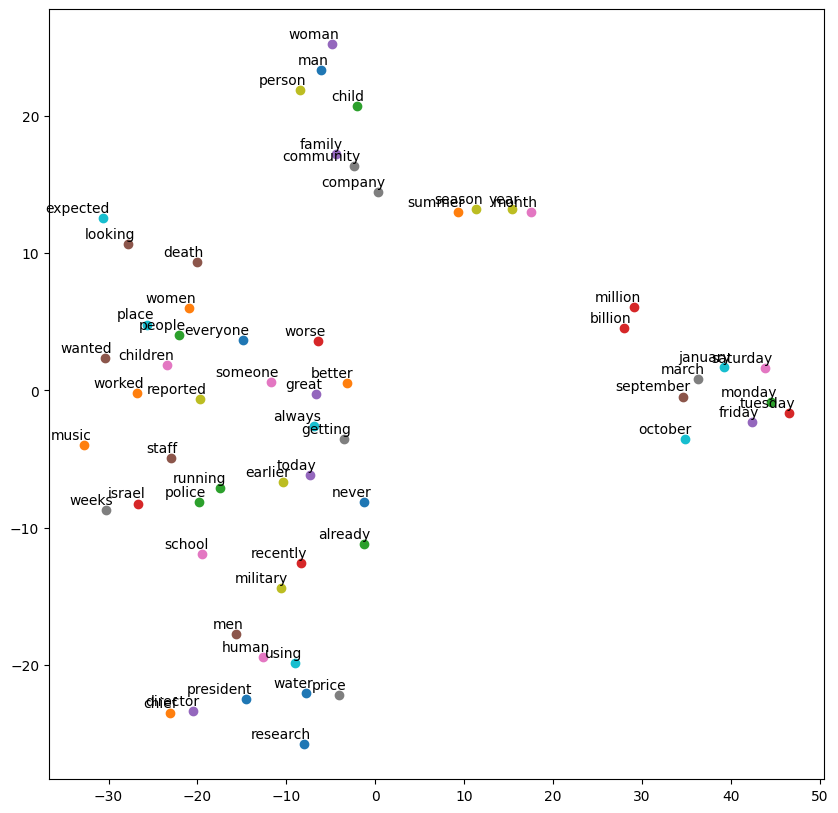

t-SNE of target words **after** training (window=5, dim=100):


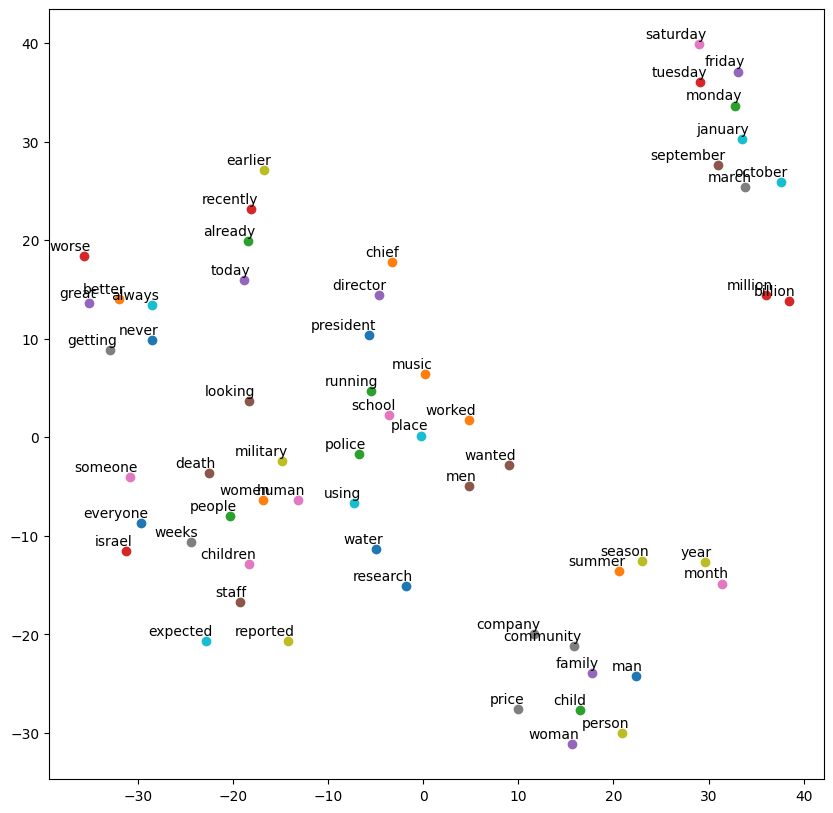

t-SNE of target words **after** training (window=5, dim=200):


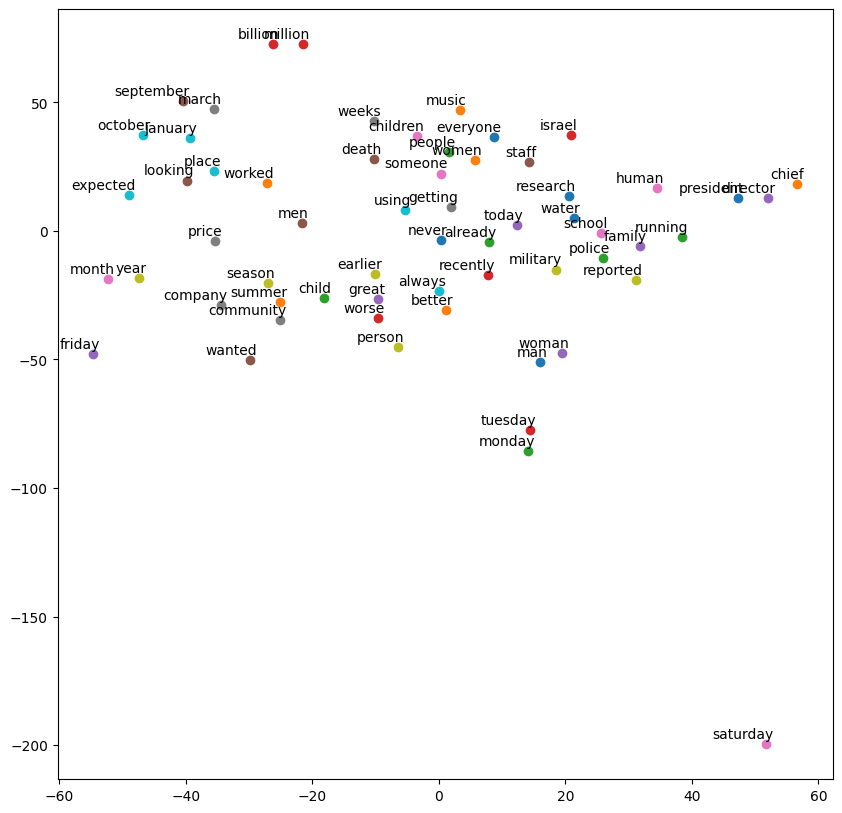

In [44]:
# 5. Qualitative Evaluation via t-SNE Visualization

# (i) Before training: visualize the random (untrained) embeddings
print("t-SNE of target words **before** training (random init):")
# Build a random CBOW model to extract its initial embedding matrix
random_model = build_cbow_model(vocab_size, window=context_windows[0], embedding_dim=embedding_dims[0])
initial_embeddings = random_model.get_layer('embedding').get_weights()[0]

# visualize_tsne_embeddings(words, embeddings, word_index, filename=None)
visualize_tsne_embeddings(
    words=target_words,
    embeddings=initial_embeddings,
    word_index=tokenizer.word_index
    )

# (ii) After training: visualize each learned embedding
for (window, dim), info in results.items():
    print(f"t-SNE of target words **after** training (window={window}, dim={dim}):")
    trained_embeddings = info['embeddings']

    # Using the same target_words list, visualize the learned embeddings
    visualize_tsne_embeddings(
        words=target_words,
        embeddings=trained_embeddings,
        word_index=tokenizer.word_index
    )


# 6. Quantitative Analysis: Classifier Comparison Across Embedding Dimensions

In this section, we evaluate how using our pretrained CBOW embeddings impacts a downstream text classification task on the Reuters dataset. The workflow is:

1. **Load & preprocess Reuters**  
   - Restrict the vocabulary to `VOCAB_SIZE`, pad all sequences to length `MAXLEN_CLS`, and one-hot encode the labels into `NUM_CLASSES` categories.

2. **Build a classifier factory**  
   - Define `build_classification_model(embeddings_matrix=None, emb_dim=100)` which returns a Conv1D-based classifier.  
   - If `embeddings_matrix` is provided, it is loaded (frozen) into the embedding layer; otherwise, a trainable embedding of size `emb_dim` is used.

3. **Compare random vs. pretrained embeddings**  
   For each `(window, dim)` key in `results` (i.e. each CBOW configuration):  
   - **Baseline**: train a classifier with randomly initialized embeddings of dimension `dim`.  
   - **Pretrained**: train the same classifier architecture, but initialize the embedding layer with the pretrained `emb_matrix` and freeze it.  
   - Evaluate both models on the test set, printing their test accuracies.

4. **Store and visualize**  
   - Save each run’s training history and test accuracy into `comparison_results`.  
   - Plot side-by-side validation accuracy and validation loss curves (dashed = random, solid = pretrained) for direct comparison of convergence behavior and final performance.

This allows us to quantify and visualize the benefit (or drawback) of initializing with our learned embeddings versus learning from scratch for each embedding dimension and context window size.



=== window=2, emb_dim=50 ===
Training baseline (random embeddings)...
Training with pretrained embeddings...
Baseline acc: 0.6839 — Pretrained acc: 0.6220


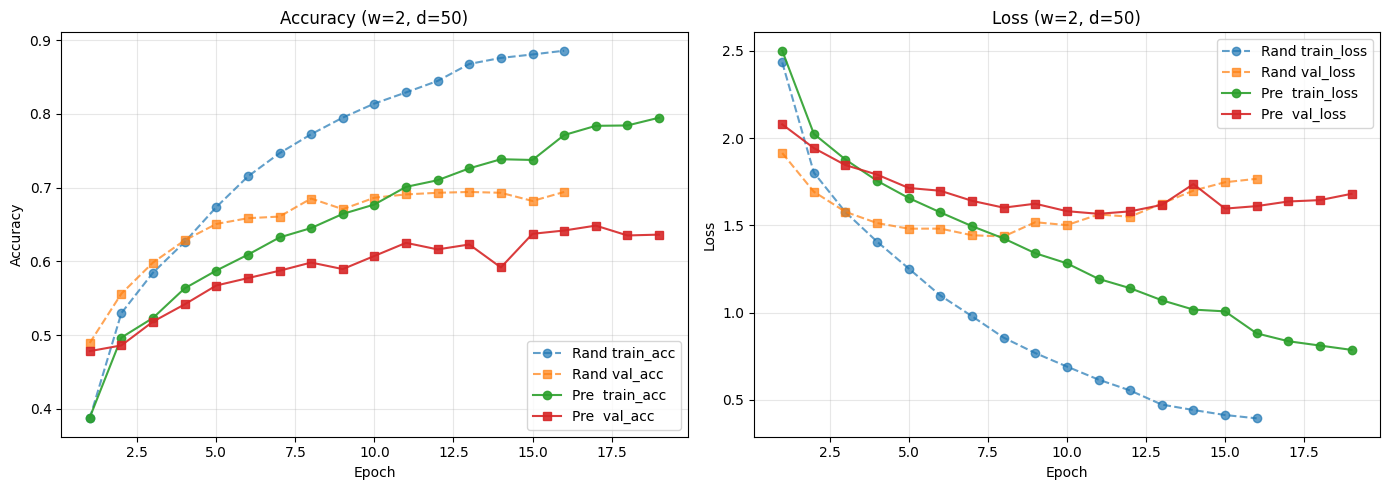


=== window=2, emb_dim=100 ===
Training baseline (random embeddings)...
Training with pretrained embeddings...
Baseline acc: 0.6598 — Pretrained acc: 0.6572


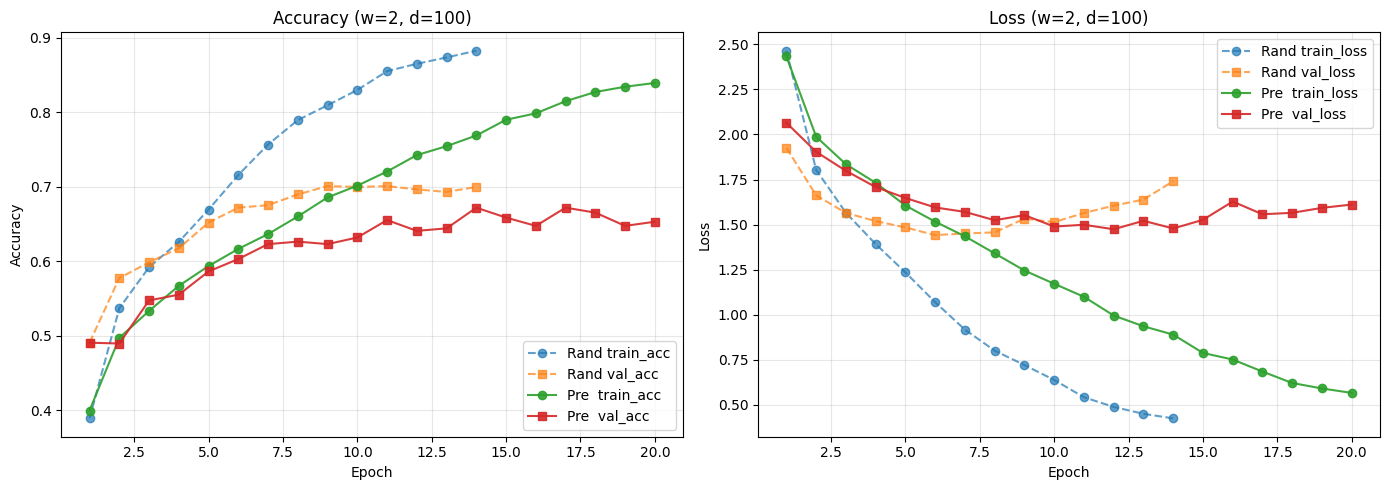


=== window=2, emb_dim=200 ===
Training baseline (random embeddings)...
Training with pretrained embeddings...
Baseline acc: 0.7093 — Pretrained acc: 0.6714


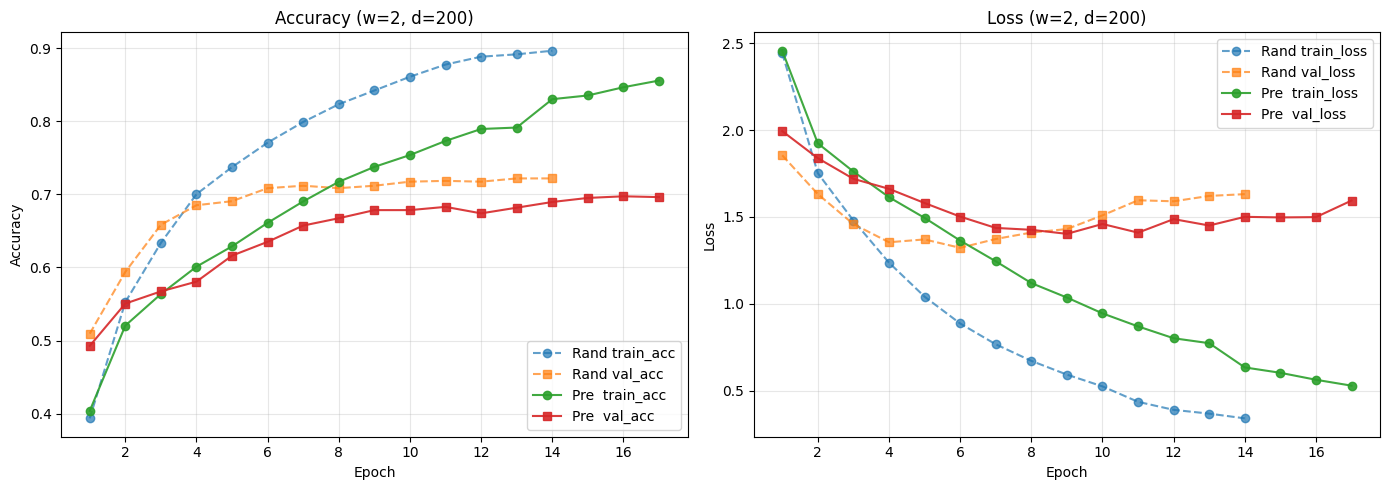


=== window=5, emb_dim=50 ===
Training baseline (random embeddings)...
Training with pretrained embeddings...
Baseline acc: 0.6785 — Pretrained acc: 0.6180


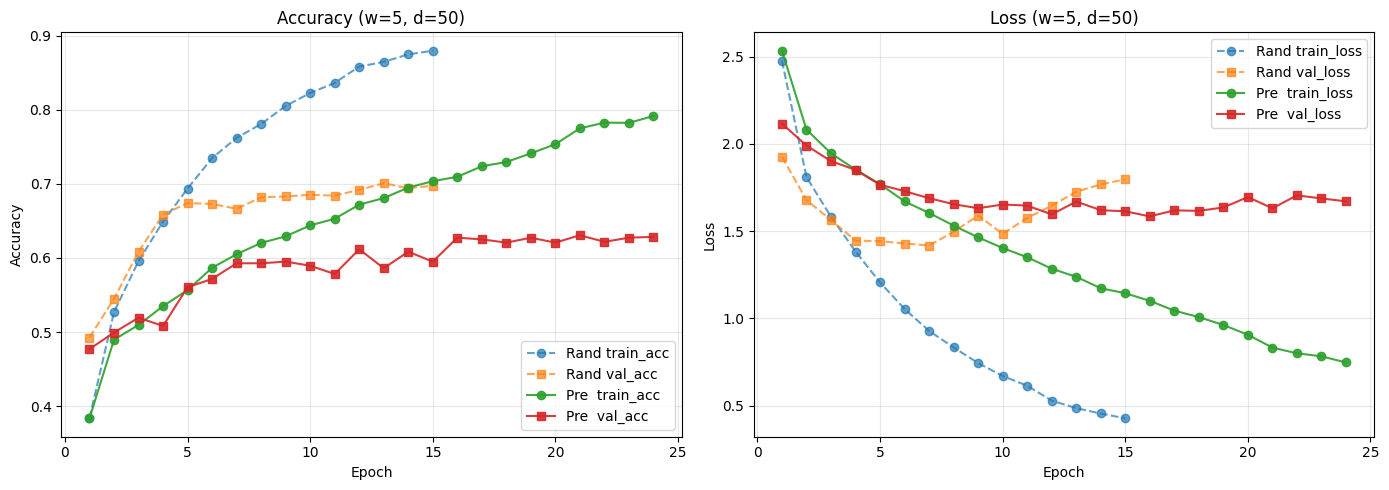


=== window=5, emb_dim=100 ===
Training baseline (random embeddings)...
Training with pretrained embeddings...
Baseline acc: 0.6670 — Pretrained acc: 0.6549


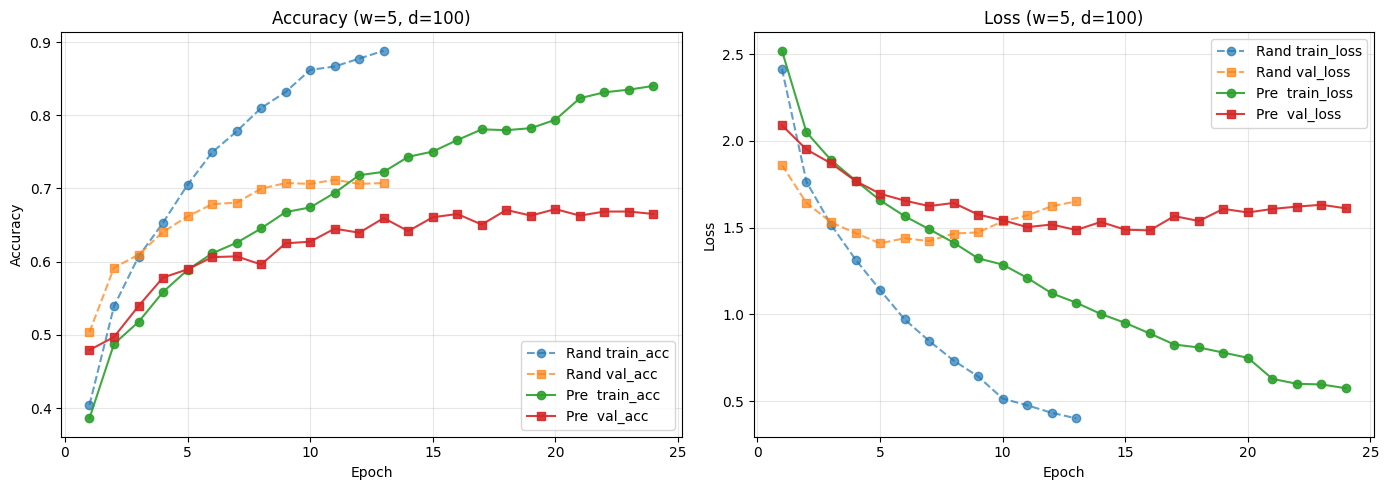


=== window=5, emb_dim=200 ===
Training baseline (random embeddings)...
Training with pretrained embeddings...
Baseline acc: 0.6946 — Pretrained acc: 0.6585


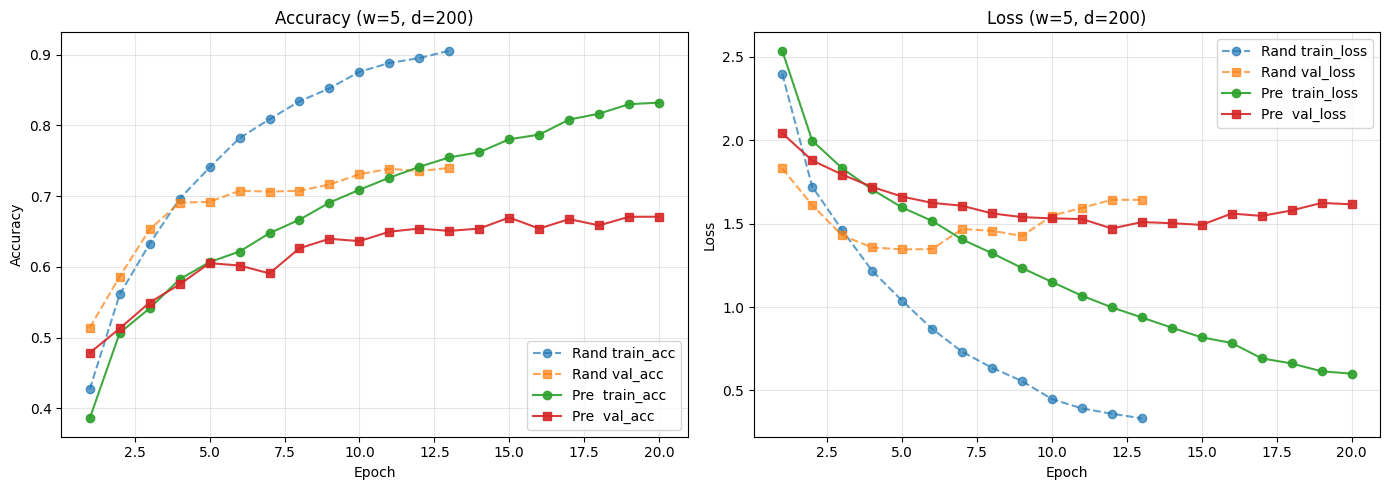

In [47]:
# 1) Load & preprocess Reuters once
VOCAB_SIZE = vocab_size  # same as used for embeddings
MAXLEN_CLS = 256

(x_train_r, y_train_r), (x_test_r, y_test_r) = reuters.load_data(num_words=VOCAB_SIZE)
x_train_r = pad_sequences(x_train_r, maxlen=MAXLEN_CLS)
x_test_r  = pad_sequences(x_test_r, maxlen=MAXLEN_CLS)

y_train_r = to_categorical(y_train_r)
y_test_r  = to_categorical(y_test_r)
NUM_CLASSES = y_train_r.shape[1]

# 2) Define classifier builder accepting an embeddings matrix
def build_classification_model(embeddings_matrix=None, emb_dim=100):
    model = Sequential()
    if embeddings_matrix is not None:
        emb_dim = embeddings_matrix.shape[1]
        model.add(Embedding(input_dim=VOCAB_SIZE,
                            output_dim=emb_dim,
                            weights=[embeddings_matrix],
                            trainable=False,
                            input_length=MAXLEN_CLS,
                            name='pretrained_emb'))
    else:
        # Random embeddings of same dim as baseline
        model.add(Embedding(input_dim=VOCAB_SIZE,
                            output_dim=emb_dim,
                            input_length=MAXLEN_CLS,
                            name='random_emb'))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# 3) Comparison loop: for each embedding dimension, train both random & pretrained
comparison_results = {}

for (window, dim), info in results.items():
    emb_matrix = info['embeddings']
    print(f"\n=== window={window}, emb_dim={dim} ===")

    # 3a) Baseline: random embeddings of size dim
    print("Training baseline (random embeddings)...")
    model_rand = build_classification_model(embeddings_matrix=None, emb_dim=dim)
    hist_rand = model_rand.fit(
        x_train_r, y_train_r,
        validation_split=0.1,
        epochs=40,
        batch_size=128,
        callbacks=get_callbacks(),
        verbose=0
    )

    # 3b) With pretrained embeddings
    print("Training with pretrained embeddings...")
    model_pre = build_classification_model(embeddings_matrix=emb_matrix)
    hist_pre = model_pre.fit(
        x_train_r, y_train_r,
        validation_split=0.1,
        epochs=40,
        batch_size=128,
        callbacks=get_callbacks(),
        verbose=0
    )

    # 3c) Evaluate on test set
    acc_rand = model_rand.evaluate(x_test_r, y_test_r, verbose=0)[1]
    acc_pre  = model_pre.evaluate(x_test_r, y_test_r, verbose=0)[1]
    print(f"Baseline acc: {acc_rand:.4f} — Pretrained acc: {acc_pre:.4f}")

    # 3d) Store histories & accuracies
    comparison_results[(window, dim)] = {
        'hist_rand': hist_rand,
        'hist_pre': hist_pre,
        'acc_rand': acc_rand,
        'acc_pre': acc_pre
    }

    # 4) Plot comparison of training & validation curves
    plt.figure(figsize=(14,5))

    # --- Accuracy subplot ---
    plt.subplot(1, 2, 1)
    # Random baseline
    epochs_rand = range(1, len(hist_rand.history['accuracy']) + 1)
    plt.plot(epochs_rand, hist_rand.history['accuracy'],
            '--o', label='Rand train_acc', alpha=0.7)
    plt.plot(epochs_rand, hist_rand.history['val_accuracy'],
            '--s', label='Rand val_acc', alpha=0.7)

    # Pretrained
    epochs_pre = range(1, len(hist_pre.history['accuracy']) + 1)
    plt.plot(epochs_pre, hist_pre.history['accuracy'],
            '-o', label='Pre  train_acc', alpha=0.9)
    plt.plot(epochs_pre, hist_pre.history['val_accuracy'],
            '-s', label='Pre  val_acc', alpha=0.9)

    plt.title(f'Accuracy (w={window}, d={dim})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)

    # --- Loss subplot ---
    plt.subplot(1, 2, 2)
    # Random baseline
    plt.plot(epochs_rand, hist_rand.history['loss'],
            '--o', label='Rand train_loss', alpha=0.7)
    plt.plot(epochs_rand, hist_rand.history['val_loss'],
            '--s', label='Rand val_loss', alpha=0.7)

    # Pretrained
    plt.plot(epochs_pre, hist_pre.history['loss'],
            '-o', label='Pre  train_loss', alpha=0.9)
    plt.plot(epochs_pre, hist_pre.history['val_loss'],
            '-s', label='Pre  val_loss', alpha=0.9)

    plt.title(f'Loss (w={window}, d={dim})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()



In [49]:
# define a new function to build the classification model
def build_classification_model2(embeddings_matrix=None, emb_dim=100):
    model = Sequential()
    if embeddings_matrix is not None:
        emb_dim = embeddings_matrix.shape[1]
        model.add(Embedding(input_dim=VOCAB_SIZE,
                            output_dim=emb_dim,
                            weights=[embeddings_matrix],
                            trainable=False,
                            input_length=MAXLEN_CLS,
                            name='pretrained_emb'))
    else:
        # Random embeddings of same dim as baseline
        model.add(Embedding(input_dim=VOCAB_SIZE,
                            output_dim=emb_dim,
                            input_length=MAXLEN_CLS,
                            name='random_emb'))
    model.add(Conv1D(256, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(Conv1D(256, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



=== window=2, emb_dim=50 ===
Training baseline (random embeddings)...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Training with pretrained embeddings...
Baseline acc: 0.6741 — Pretrained acc: 0.6456


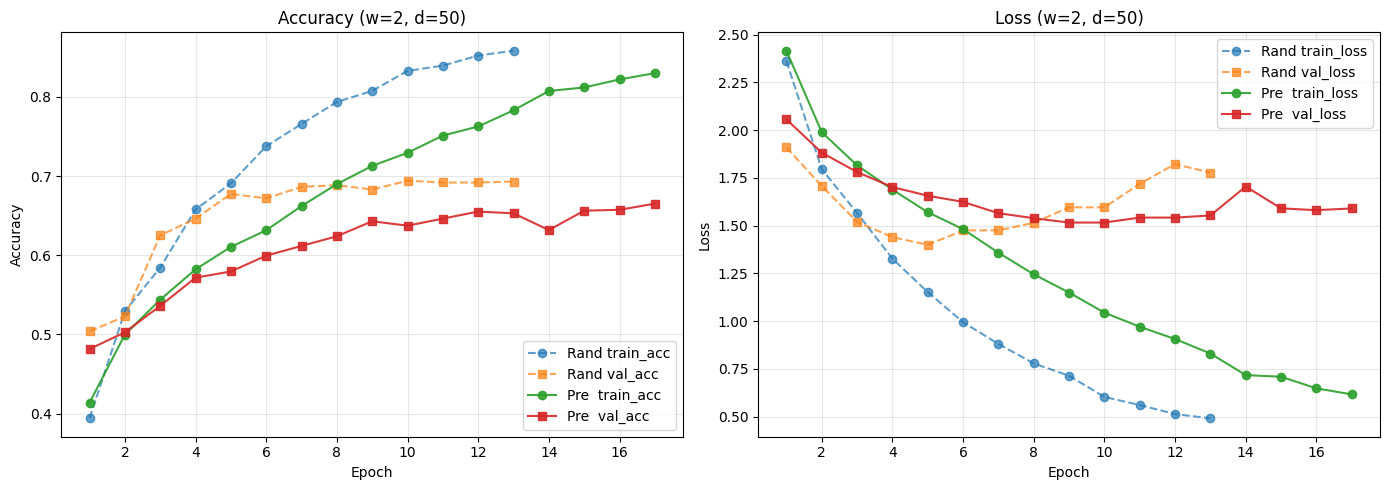


=== window=2, emb_dim=100 ===
Training baseline (random embeddings)...
Training with pretrained embeddings...
Baseline acc: 0.7035 — Pretrained acc: 0.6754


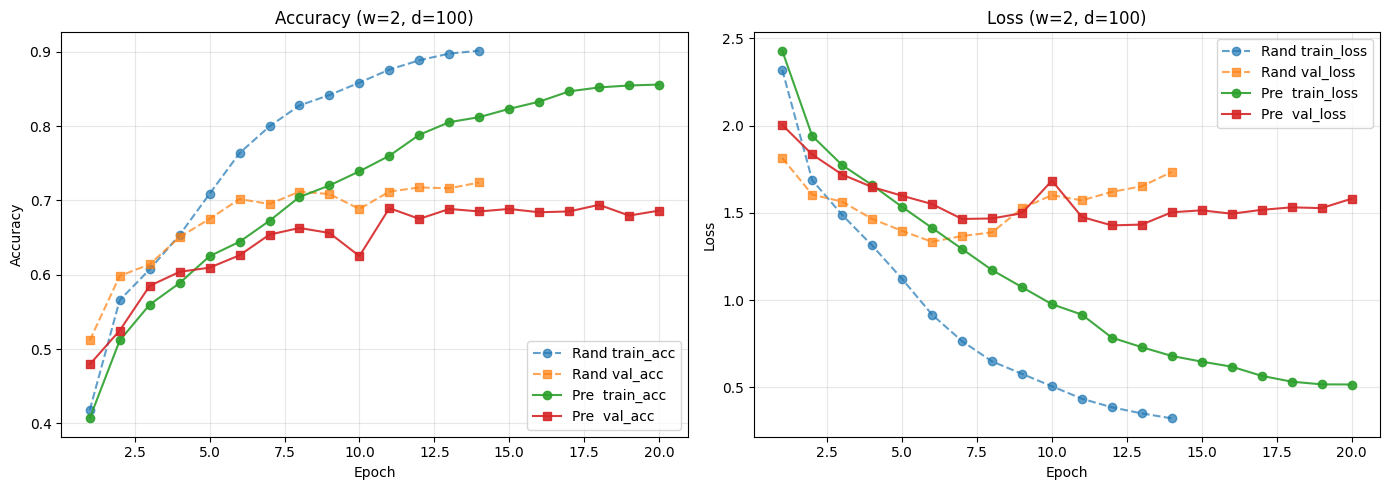


=== window=2, emb_dim=200 ===
Training baseline (random embeddings)...
Training with pretrained embeddings...
Baseline acc: 0.6928 — Pretrained acc: 0.6959


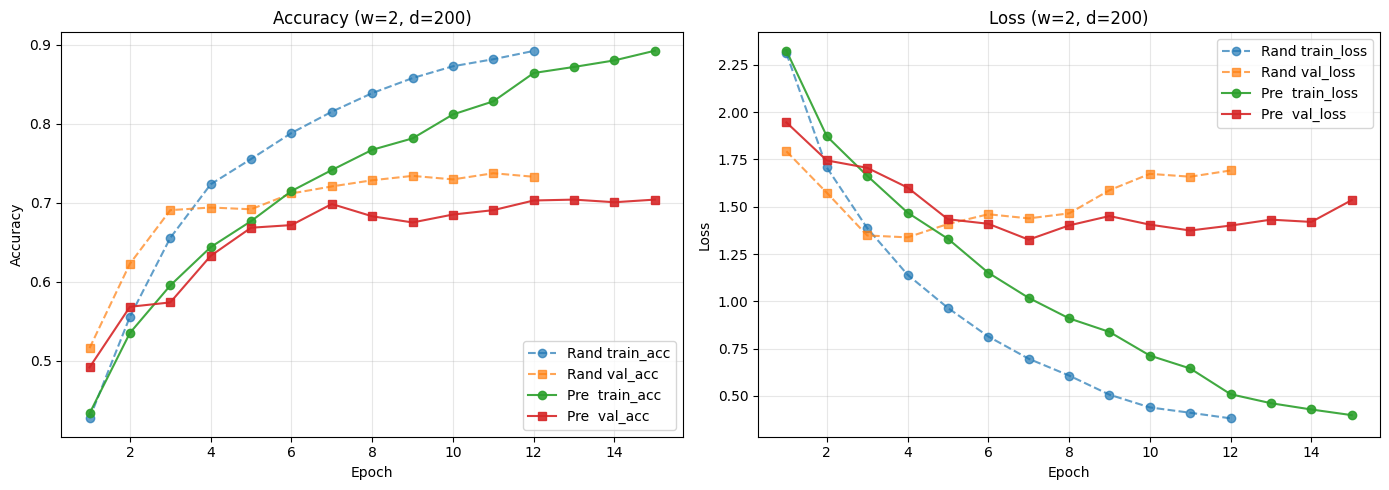


=== window=5, emb_dim=50 ===
Training baseline (random embeddings)...
Training with pretrained embeddings...
Baseline acc: 0.6451 — Pretrained acc: 0.6291


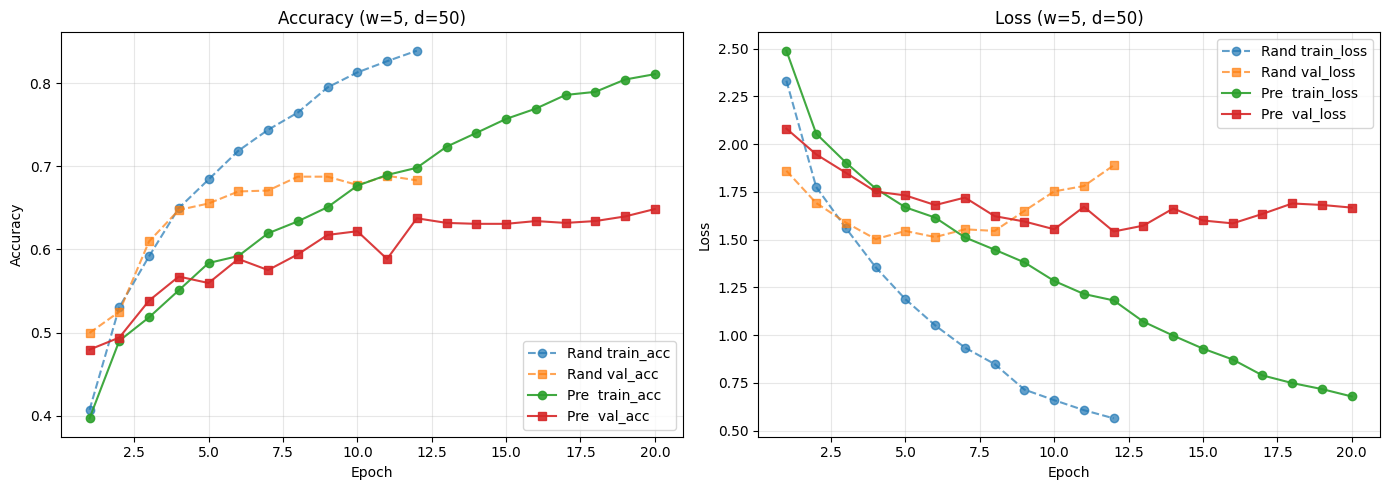


=== window=5, emb_dim=100 ===
Training baseline (random embeddings)...
Training with pretrained embeddings...
Baseline acc: 0.6736 — Pretrained acc: 0.6687


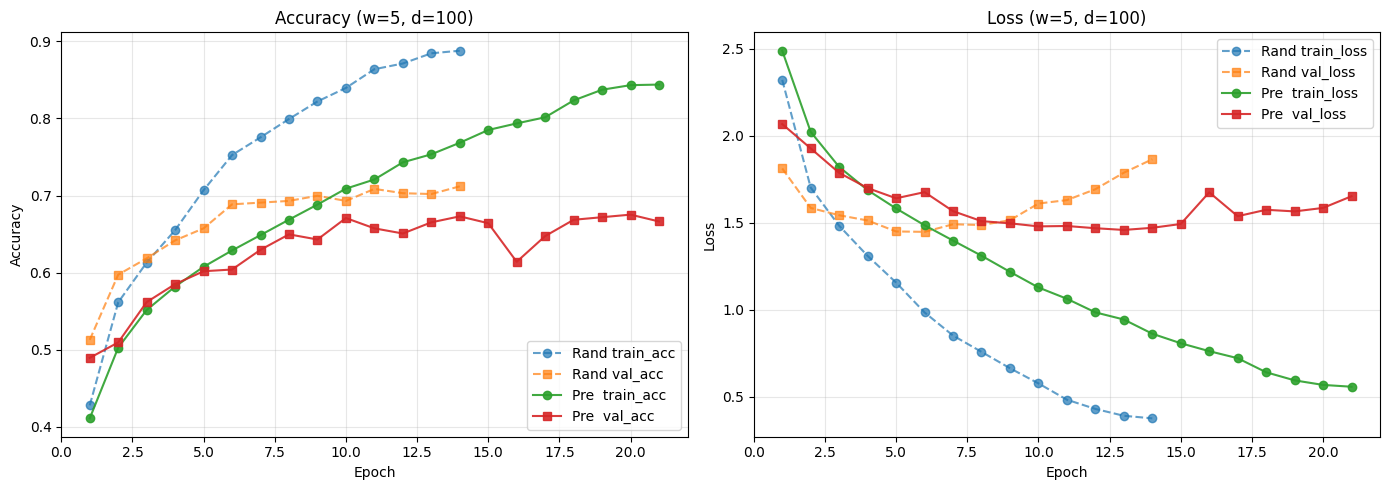


=== window=5, emb_dim=200 ===
Training baseline (random embeddings)...
Training with pretrained embeddings...
Baseline acc: 0.6986 — Pretrained acc: 0.6843


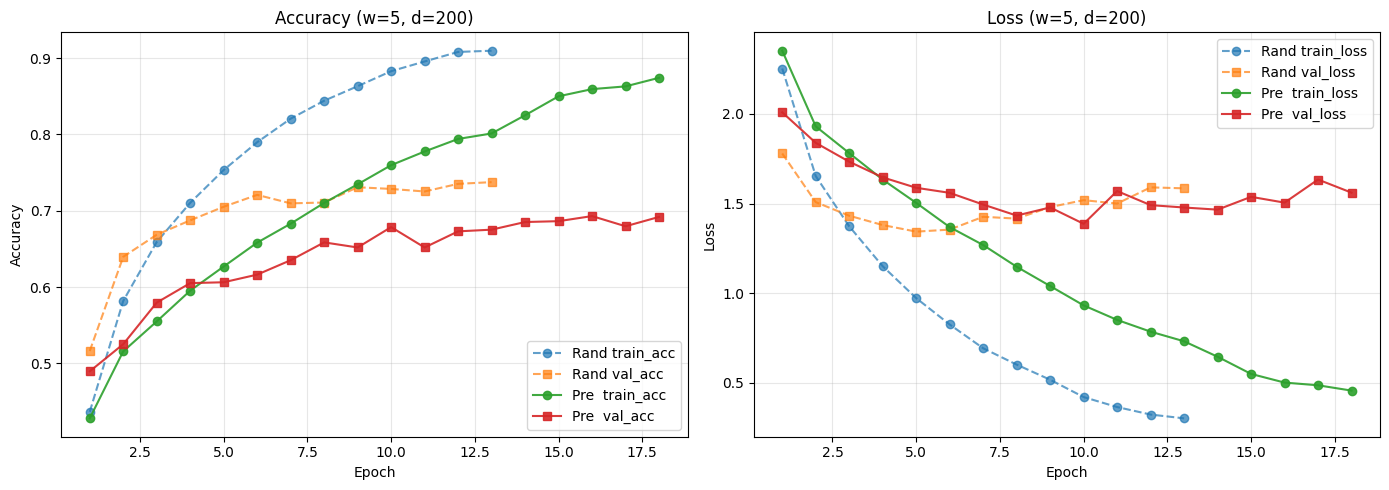

In [50]:
comparison_results2 = {}

for (window, dim), info in results.items():
    emb_matrix = info['embeddings']
    print(f"\n=== window={window}, emb_dim={dim} ===")

    # 3a) Baseline: random embeddings of size dim
    print("Training baseline (random embeddings)...")
    model_rand = build_classification_model2(embeddings_matrix=None, emb_dim=dim)
    hist_rand = model_rand.fit(
        x_train_r, y_train_r,
        validation_split=0.1,
        epochs=40,
        batch_size=128,
        callbacks=get_callbacks(),
        verbose=0
    )

    # 3b) With pretrained embeddings
    print("Training with pretrained embeddings...")
    model_pre = build_classification_model2(embeddings_matrix=emb_matrix)
    hist_pre = model_pre.fit(
        x_train_r, y_train_r,
        validation_split=0.1,
        epochs=40,
        batch_size=128,
        callbacks=get_callbacks(),
        verbose=0
    )

    # 3c) Evaluate on test set
    acc_rand = model_rand.evaluate(x_test_r, y_test_r, verbose=0)[1]
    acc_pre  = model_pre.evaluate(x_test_r, y_test_r, verbose=0)[1]
    print(f"Baseline acc: {acc_rand:.4f} — Pretrained acc: {acc_pre:.4f}")

    # 3d) Store histories & accuracies
    comparison_results2[(window, dim)] = {
        'hist_rand': hist_rand,
        'hist_pre': hist_pre,
        'acc_rand': acc_rand,
        'acc_pre': acc_pre
    }

    # 4) Plot comparison of training & validation curves
    plt.figure(figsize=(14,5))

    # --- Accuracy subplot ---
    plt.subplot(1, 2, 1)
    # Random baseline
    epochs_rand = range(1, len(hist_rand.history['accuracy']) + 1)
    plt.plot(epochs_rand, hist_rand.history['accuracy'],
            '--o', label='Rand train_acc', alpha=0.7)
    plt.plot(epochs_rand, hist_rand.history['val_accuracy'],
            '--s', label='Rand val_acc', alpha=0.7)

    # Pretrained
    epochs_pre = range(1, len(hist_pre.history['accuracy']) + 1)
    plt.plot(epochs_pre, hist_pre.history['accuracy'],
            '-o', label='Pre  train_acc', alpha=0.9)
    plt.plot(epochs_pre, hist_pre.history['val_accuracy'],
            '-s', label='Pre  val_acc', alpha=0.9)

    plt.title(f'Accuracy (w={window}, d={dim})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)

    # --- Loss subplot ---
    plt.subplot(1, 2, 2)
    # Random baseline
    plt.plot(epochs_rand, hist_rand.history['loss'],
            '--o', label='Rand train_loss', alpha=0.7)
    plt.plot(epochs_rand, hist_rand.history['val_loss'],
            '--s', label='Rand val_loss', alpha=0.7)

    # Pretrained
    plt.plot(epochs_pre, hist_pre.history['loss'],
            '-o', label='Pre  train_loss', alpha=0.9)
    plt.plot(epochs_pre, hist_pre.history['val_loss'],
            '-s', label='Pre  val_loss', alpha=0.9)

    plt.title(f'Loss (w={window}, d={dim})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()



In [53]:
def build_classification_model3(embeddings_matrix=None, emb_dim=100, finetune=False):
    """
    If embeddings_matrix is None → random embeddings of size emb_dim;
    else → load embeddings_matrix (shape [vocab, emb_dim]) into the layer,
    with trainable=finetune.
    """
    model = Sequential()
    if embeddings_matrix is not None:
        emb_dim = embeddings_matrix.shape[1]
        model.add(Embedding(input_dim=VOCAB_SIZE,
                            output_dim=emb_dim,
                            weights=[embeddings_matrix],
                            trainable=finetune,
                            input_length=MAXLEN_CLS,
                            name='pretrained_emb'))
    else:
        model.add(Embedding(input_dim=VOCAB_SIZE,
                            output_dim=emb_dim,
                            trainable=True,
                            input_length=MAXLEN_CLS,
                            name='random_emb'))
    model.add(Conv1D(256, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(Conv1D(256, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# 3) Train & compare three variants for each (window, dim)
comparison_results3 = {}

for (window, dim), info in results.items():
    emb_matrix = info['embeddings']
    print(f"\n=== window={window}, emb_dim={dim} ===")

    for label, emb_arg, finetune in [
        ("Baseline",           None,       False),
        ("Pretrained Frozen",  emb_matrix, False),
        ("Pretrained Finetuned", emb_matrix, True),
    ]:
        print(f"-- {label} --")
        model = build_classification_model3(
            embeddings_matrix=emb_arg,
            emb_dim=dim,
            finetune=finetune
        )
        history = model.fit(
            x_train_r, y_train_r,
            validation_split=0.1,
            epochs=40,
            batch_size=128,
            callbacks=get_callbacks(),
            verbose=0
        )
        acc = model.evaluate(x_test_r, y_test_r, verbose=0)[1]
        print(f"{label} Test Accuracy: {acc:.4f}")

        comparison_results3[(window, dim, label)] = {
            'history': history,
            'accuracy': acc
        }

# 4) Plot only validation curves per variant
for key, stats in comparison_results.items():
    # Unpack key
    if isinstance(key, tuple) and len(key) == 3:
        window, dim, label = key
    elif isinstance(key, tuple) and len(key) == 2:
        window, dim = key
        label = f"w={window}, d={dim}"
    else:
        label = str(key)

    # Retrieve History object
    if hasattr(stats, 'history'):
        hist_obj = stats
    elif isinstance(stats, dict) and 'history' in stats:
        hist_obj = stats['history']
    else:
        # Skip entries without a history
        continue

    # Validation data
    val_acc  = hist_obj.history.get('val_accuracy', [])
    val_loss = hist_obj.history.get('val_loss', [])
    epochs_val = range(1, len(val_acc) + 1)

    plt.figure(figsize=(8,4))

    # Validation Accuracy
    plt.subplot(1,2,1)
    plt.plot(epochs_val, val_acc, '-s', label='val_accuracy')
    plt.title(f"{label}\nValidation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(alpha=0.3)

    # Validation Loss
    plt.subplot(1,2,2)
    plt.plot(epochs_val, val_loss, '-s', label='val_loss')
    plt.title(f"{label}\nValidation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()




=== window=2, emb_dim=50 ===
-- Baseline --
Baseline Test Accuracy: 0.6616
-- Pretrained Frozen --
Pretrained Frozen Test Accuracy: 0.6474
-- Pretrained Finetuned --
Pretrained Finetuned Test Accuracy: 0.7208

=== window=2, emb_dim=100 ===
-- Baseline --
Baseline Test Accuracy: 0.7053
-- Pretrained Frozen --
Pretrained Frozen Test Accuracy: 0.6674
-- Pretrained Finetuned --
Pretrained Finetuned Test Accuracy: 0.6879

=== window=2, emb_dim=200 ===
-- Baseline --
Baseline Test Accuracy: 0.7244
-- Pretrained Frozen --
Pretrained Frozen Test Accuracy: 0.6923
-- Pretrained Finetuned --
Pretrained Finetuned Test Accuracy: 0.6946

=== window=5, emb_dim=50 ===
-- Baseline --
Baseline Test Accuracy: 0.6999
-- Pretrained Frozen --
Pretrained Frozen Test Accuracy: 0.6318
-- Pretrained Finetuned --
Pretrained Finetuned Test Accuracy: 0.6763

=== window=5, emb_dim=100 ===
-- Baseline --
Baseline Test Accuracy: 0.6857
-- Pretrained Frozen --
Pretrained Frozen Test Accuracy: 0.6411
-- Pretrained Fin

KeyError: 'history'

de aqui pabajo yo lo borraba

In [ ]:
#otra prueba unificando un poco de todo
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

(x_train_r, y_train_r), (x_test_r, y_test_r) = reuters.load_data(num_words=vocab_size)

# preprocess data
maxlen_cls = 256
x_train_r = pad_sequences(x_train_r, maxlen=maxlen_cls)
x_test_r = pad_sequences(x_test_r, maxlen=maxlen_cls)
y_train_r = to_categorical(y_train_r)
y_test_r = to_categorical(y_test_r)
num_classes = y_train_r.shape[1]

# define model builder functions
def build_model(use_pretrained=False, finetune=False):
    model = Sequential()
    if use_pretrained:
        model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                            weights=[embeddings], trainable=finetune, input_length=maxlen_cls))
    else:
        model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                            input_length=maxlen_cls))

    model.add(Conv1D(256, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(Conv1D(256, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# train models
# Baseline (random embeddings)
model_base = build_model(use_pretrained=False)
history_base = model_base.fit(x_train_r, y_train_r, validation_split=0.1, epochs=20, batch_size=128, verbose=2)

# Pretrained embeddings (frozen)
model_pre = build_model(use_pretrained=True, finetune=False)
history_pre = model_pre.fit(x_train_r, y_train_r, validation_split=0.1, epochs=20, batch_size=128, verbose=2)

# Pretrained embeddings (fine-tuned)
model_pre_finetuned = build_model(use_pretrained=True, finetune=True)
history_pre_finetuned = model_pre_finetuned.fit(x_train_r, y_train_r, validation_split=0.1, epochs=20, batch_size=128, verbose=2)

# Evaluate models
baseline_accuracy = model_base.evaluate(x_test_r, y_test_r, verbose=0)[1]
pretrained_accuracy = model_pre.evaluate(x_test_r, y_test_r, verbose=0)[1]
pretrained_finetuned_accuracy = model_pre_finetuned.evaluate(x_test_r, y_test_r, verbose=0)[1]

print(f'Baseline Test Accuracy: {baseline_accuracy:.4f}')
print(f'Pretrained (Frozen) Test Accuracy: {pretrained_accuracy:.4f}')
print(f'Pretrained (Fine-tuned) Test Accuracy: {pretrained_finetuned_accuracy:.4f}')


Epoch 1/20
64/64 - 5s - 81ms/step - accuracy: 0.4356 - loss: 2.3438 - val_accuracy: 0.5117 - val_loss: 1.8258
Epoch 2/20
64/64 - 4s - 58ms/step - accuracy: 0.5564 - loss: 1.7139 - val_accuracy: 0.6051 - val_loss: 1.6140
Epoch 3/20
64/64 - 4s - 57ms/step - accuracy: 0.6117 - loss: 1.4914 - val_accuracy: 0.6374 - val_loss: 1.5127
Epoch 4/20
64/64 - 4s - 58ms/step - accuracy: 0.6740 - loss: 1.3016 - val_accuracy: 0.6752 - val_loss: 1.3698
Epoch 5/20
64/64 - 4s - 60ms/step - accuracy: 0.7225 - loss: 1.1144 - val_accuracy: 0.6785 - val_loss: 1.3973
Epoch 6/20
64/64 - 4s - 55ms/step - accuracy: 0.7512 - loss: 0.9739 - val_accuracy: 0.6897 - val_loss: 1.4355
Epoch 7/20
64/64 - 4s - 55ms/step - accuracy: 0.7857 - loss: 0.8386 - val_accuracy: 0.6997 - val_loss: 1.4127
Epoch 8/20
64/64 - 4s - 59ms/step - accuracy: 0.8056 - loss: 0.7494 - val_accuracy: 0.7086 - val_loss: 1.4449
Epoch 9/20
64/64 - 4s - 59ms/step - accuracy: 0.8214 - loss: 0.6725 - val_accuracy: 0.7008 - val_loss: 1.4591
Epoch 10/2

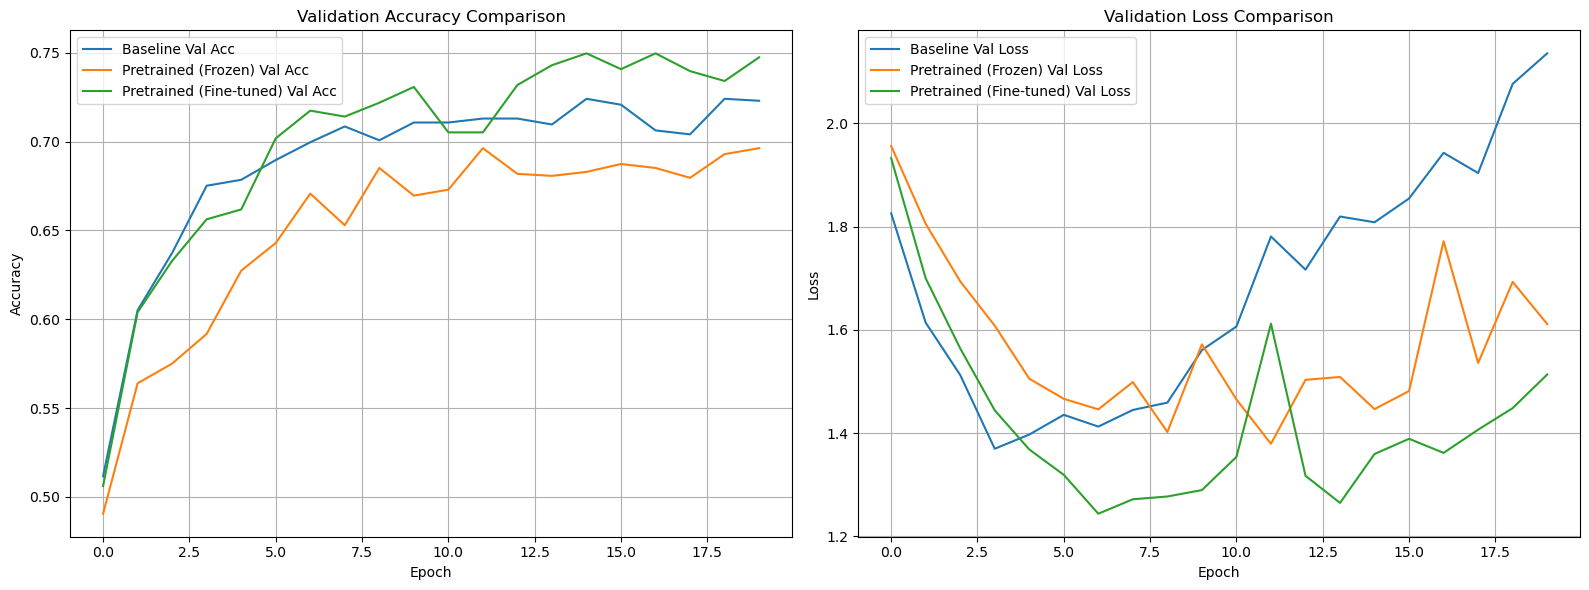

Models saved successfully!


In [ ]:
# plot training history
plt.figure(figsize=(16, 6))

# accuracy
plt.subplot(1, 2, 1)
plt.plot(history_base.history['val_accuracy'], label='Baseline Val Acc')
plt.plot(history_pre.history['val_accuracy'], label='Pretrained (Frozen) Val Acc')
plt.plot(history_pre_finetuned.history['val_accuracy'], label='Pretrained (Fine-tuned) Val Acc')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# loss
plt.subplot(1, 2, 2)
plt.plot(history_base.history['val_loss'], label='Baseline Val Loss')
plt.plot(history_pre.history['val_loss'], label='Pretrained (Frozen) Val Loss')
plt.plot(history_pre_finetuned.history['val_loss'], label='Pretrained (Fine-tuned) Val Loss')
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# save models
model_base.save('model_baseline.h5')
model_pre.save('model_pretrained_frozen.h5')
model_pre_finetuned.save('model_pretrained_finetuned.h5')

print("Models saved successfully!")

# 10. Discussion and Next Steps

- Analyze results: impact of context window, embedding dim, pretrained vs scratch
- Explore larger corpora or external embeddings (fastText, Gensim)
- Document findings and prepare report (max 3 pages)
- Prepare defense slides